# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance,variance_decomposition_ex_post
from PnL_Computation import PnL
from Stock_Data import get_close
from Rebalancing import *
from Git import *

In [2]:
git=GitHub(token,repo_owner,repo_name,branch)
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

# Loading Benchmark

In [3]:
start_date=datetime.datetime(2020,1,1)
today=datetime.datetime.today()
days=(today-start_date).days
remaining=days%500
numbers_of_table=days//500
tickers=Binance.get_market_cap()['Ticker'].iloc[:40].to_list()
temp_end=start_date
scope_prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    scope_prices=scope_prices.combine_first(data)
    
temp_end=(today-datetime.timedelta(remaining))
data=Binance.get_price(tickers,temp_end)
scope_prices=scope_prices.combine_first(data)
scope_prices=scope_prices.sort_index()
scope_prices = scope_prices[~scope_prices.index.duplicated(keep='first')]
scope_prices.index=pd.to_datetime(scope_prices.index)
tickers2=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()
prices=scope_prices[tickers2]
returns=np.log(1+prices.pct_change(fill_method=None))
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na].sort_index()
dataframe=prices[with_no_na].sort_index()
dataframe.index=pd.to_datetime(dataframe.index)
returns_to_use.index=pd.to_datetime(returns_to_use.index)
returns_to_use = returns_to_use[~returns_to_use.index.duplicated(keep='first')]

month=list(sorted(set(returns_to_use.index + pd.offsets.BMonthEnd(0))))
#month_end=pd.to_datetime(mrat_wo_na.index)
month = pd.to_datetime(month)

idx1 = pd.Index(returns_to_use.iloc[:-1].index)
idx2 = pd.Index(month)
closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]

dates_end=list(closest_dates)
dates_end.insert(0,returns_to_use.index[1])
dates_end.append(returns_to_use.index[-1])
dates_end=sorted(list(set(dates_end)))
dates_end.pop(0)
dates_end=sorted(list(set(dates_end)))

results={}

if 'USDCUSDT' in returns_to_use.columns:
    
    cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

else:

    cash=[]
# gold_positions=np.where(returns_to_use.columns=='GOLD.PA')[0][0]
#om_limit=np.where(returns_to_use.columns=='OMUSDT')[0][0]

for i in range(len(dates_end)-1):
    
    try:
        dataset=returns_to_use.loc[dates_end[i]:dates_end[i+1]]        
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        
        optimal=risk.optimize(objective='minimum_variance',constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00}#,
                                                                       ])# {'type': 'eq', 'fun': lambda weights: weights[gold_positions]-0.00}])
        
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
        pass

rolling_optimization=pd.DataFrame(results,index=dataframe.columns).T
rolling_optimization.loc[dates_end[0]]=1/len(dataframe.columns)
rolling_optimization=rolling_optimization.sort_index()

performance_model=pd.DataFrame()

In [4]:
q=rebalanced_dynamic_quantities(dataframe,rolling_optimization.iloc[:-2])
results=q*dataframe

performance_model['Fund']=results.sum(axis=1)
performance_model['Bitcoin']=dataframe['BTCUSDT']
#performance['Mantra']=dataframe['OMUSDT']

performance_model_pct=performance_model.copy()
performance_model_pct=performance_model_pct.pct_change(fill_method=None)

# Importing Data

In [5]:
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [6]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [7]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [8]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [9]:
quantities_api=Binance.binance_api.user_asset()

current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [10]:
# trade_history=pd.read_excel('Trades USDT.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))

In [11]:
price=Pnl_calculation.get_trade_in_usdt(trade_history)

BTCUSDT 0
TRXUSDT 1
TRXUSDT 2
TRXUSDT 3
BTCUSDT 4
TRXUSDT 5
BNBUSDT 6
ETHUSDT 7
SOLUSDT 8
BNBUSDT 9
USDTTRY 10
JASMYUSDT 11
BNBUSDT 12
BBUSDT 13
USDTTRY 14
BNBUSDT 15
USDTTRY 16
TRXUSDT 17
USDTTRY 18
JASMYUSDT 19
BNBUSDT 20
BBUSDT 21
OMUSDT 22
OMUSDT 23
OMUSDT 24
TRXUSDT 25
BTCUSDT 26
OMUSDT 27
BTCUSDT 28
TRXUSDT 29
TRXUSDT 30
BBUSDT 31
BNBUSDT 32
TRXUSDT 33
BTCUSDT 34
TRXUSDT 35
BTCUSDT 36
MKRUSDT 37
BTCUSDT 38
MKRUSDT 39
EURUSDT 40
EURUSDT 41
BBUSDT 42
BNBUSDT 43
JASMYUSDT 44
PEPEUSDT 45
NOTUSDT 46
NOTUSDT 47
NOTUSDT 48
BBUSDT 49
BBUSDT 50
PEPEUSDT 51
JASMYUSDT 52
BTCUSDT 53
BTCUSDT 54
TRXUSDT 55
BTCUSDT 56
BNBUSDT 57
BTCUSDT 58
BNBUSDT 59
BTCUSDT 60
BNBUSDT 61
BTCUSDT 62
BNBUSDT 63
BTCUSDT 64
BNBUSDT 65
BNBUSDT 66
BTCUSDT 67
BNBUSDT 68
JASMYUSDT 69
JASMYUSDT 70
ENSUSDT 71
ARUSDT 72
BTCUSDT 73
UMAUSDT 74
BTCUSDT 75
UMAUSDT 76
ETHUSDT 77
XRPUSDT 78
BTCUSDT 79
XRPUSDT 80
BTCUSDT 81
NEARUSDT 82
BTCUSDT 83
LPTUSDT 84
BTCUSDT 85
NEARUSDT 86
EURUSDT 87
BTCUSDT 88
INJUSDT 89
BTCUSDT 90
FETU

In [12]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

historical_positions.rename(columns={'TRYUSDT': 'USDTTRY'}, inplace=True)

In [13]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_482756\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [14]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()


In [15]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:80].to_list()

In [16]:
holding=Binance.get_inventory()
last_prices=Binance.get_price(list(q.iloc[-1].keys()))

positions=pd.DataFrame(q.iloc[-1]*last_prices).T
positions['Weights Model']=positions[positions.columns]/positions[positions.columns].sum()

condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
holding_tickers.remove("USDCUSDT")
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,last_book_cost,holding.loc[condition],positions['Weights Model'],realized_pnl],axis=1)
pnl.columns=['Average Cost','Book Cost','Price in USDT','Weights','Weights Model','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Average Cost']=np.nan

pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100
pnl.sort_values(by='Weights',ascending=False).round(4)

,Average Cost,Book Cost,Price in USDT,Weights,Weights Model,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,NaN,1979.7299,2069.0770,1.0000,1.0000,-28.6129,117.96,89.3471,4.5131
BTCUSDT,74833.4149,911.2802,1389.4194,0.6715,0.7015,13.0697,478.14,491.2097,24.8120
TRXUSDT,0.2647,512.9871,625.3566,0.3022,0.2985,80.2793,112.37,192.6493,9.7311
OMUSDT,1.1299,526.3213,53.7074,0.0260,0.0000,0.0000,-472.61,-472.6100,-23.8724
USDCUSDT,0.0000,0.0000,0.3226,0.0002,0.0000,0.0000,0.00,0.0000,0.0000
ETHUSDT,3654.5327,0.1328,0.1505,0.0001,0.0000,55.9949,0.02,56.0149,2.8294
DOGEUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000
ADAUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000
LPTUSDT,23.2081,0.0000,0.0000,0.0000,0.0000,-5.7459,0.00,-5.7459,-0.2902
SOLUSDT,157.0560,0.0696,0.0864,0.0000,0.0000,85.7303,0.02,85.7503,4.3314


In [17]:
selling_amount=pd.DataFrame()

selling_amount['Portfolio']=pnl['Weights']
selling_amount['Model']=pnl['Weights Model']
selling_amount['Positions']=pnl['Price in USDT']

selling_amount['Model Positions']=selling_amount['Model']*selling_amount.loc['Total','Positions']
selling_amount['Spread']=selling_amount['Model Positions']-selling_amount['Positions']
selling_amount.sort_values(by='Model',ascending=False).round(2)

,Portfolio,Model,Positions,Model Positions,Spread
Total,1.00,1.0,2069.08,2069.08,0.00
BTCUSDT,0.67,0.7,1389.42,1451.37,61.96
TRXUSDT,0.30,0.3,625.36,617.70,-7.65
MKRUSDT,0.00,0.0,0.00,0.00,0.00
XLMUSDT,0.00,0.0,0.00,0.00,0.00
BCHUSDT,0.00,0.0,0.00,0.00,0.00
LINKUSDT,0.00,0.0,0.00,0.00,0.00
ADAUSDT,0.00,0.0,0.00,0.00,0.00
DOGEUSDT,0.00,0.0,0.00,0.00,0.00
USDCUSDT,0.00,0.0,0.32,0.00,-0.32


In [18]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [19]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [20]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [21]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')
inventory_weights.pop('USDCUSDT')


if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [22]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [23]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [24]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: cb80ca893f69cfd823a335e3807abaf0d554ab0f)
✅ File pushed/updated successfully!


In [25]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [26]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [27]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [28]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: fdc9ad41d90ae6a846e92f215c08f68e52ba7654)
✅ File pushed/updated successfully!


In [29]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [30]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [31]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()
cols=quantities.columns[quantities.columns!='USDCUSDT']

for col in cols:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index] 

In [32]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [33]:
# pnl_history['Total']

In [34]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [35]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [36]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [37]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in cols:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [38]:
pnl_history['Total']

2024-09-23   -247.226270
2024-09-24   -303.288508
2024-09-25   -320.535015
2024-09-26   -234.835798
2024-09-27   -218.316677
                 ...    
2025-10-07   -141.262944
2025-10-08   -108.445510
2025-10-09   -139.379054
2025-10-10   -306.307342
2025-10-11     53.493721
Name: Total, Length: 384, dtype: float64

<Axes: >

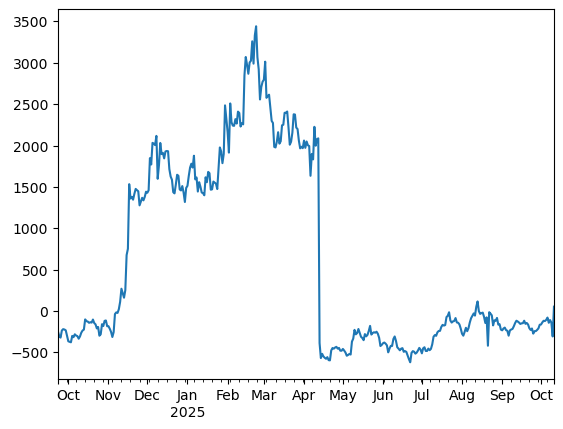

In [39]:
pnl_history['Total'].plot()

In [40]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl[-31:]

2025-09-11     38.330067
2025-09-12     28.157845
2025-09-13     -9.210608
2025-09-14    -12.518451
2025-09-15    -17.024334
2025-09-16      7.182172
2025-09-17      1.849051
2025-09-18     29.806058
2025-09-19    -37.805603
2025-09-20     10.375811
2025-09-21    -18.452314
2025-09-22    -45.323121
2025-09-23    -20.406501
2025-09-24     17.724228
2025-09-25    -61.920400
2025-09-26     29.559911
2025-09-27      0.855447
2025-09-28     14.379318
2025-09-29     18.308190
2025-09-30     44.140745
2025-10-01      2.513205
2025-10-02     25.932412
2025-10-03     19.426799
2025-10-04     -3.164062
2025-10-05     14.336500
2025-10-06     27.547427
2025-10-07    -62.874522
2025-10-08     32.817434
2025-10-09    -30.933544
2025-10-10   -166.928288
2025-10-11    359.801063
Name: Total, dtype: float64

In [41]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']

var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-366.647704000073, -950.5160328166937)

In [42]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [43]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [44]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [45]:
start_date=datetime.datetime(2024,5,11)
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(weights_ex_post.columns,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(weights_ex_post.columns,temp_end)
binance_data=prices.combine_first(last_data)
binance_data=binance_data.sort_index()
binance_data = binance_data[~binance_data.index.duplicated(keep='first')]
binance_data.index=pd.to_datetime(binance_data.index)

LDUMAUSDT not retrieved
Total not retrieved
LDUMAUSDT not retrieved
Total not retrieved
LDUMAUSDT not retrieved
Total not retrieved


In [46]:
binance_data=np.log(1+binance_data.pct_change())

C:\Users\niroo\AppData\Local\Temp\ipykernel_482756\2713676895.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [47]:
weight_date=set(weights_ex_post.index)
binance_date=set(binance_data.index)

In [48]:
common_date=weight_date.intersection(binance_date)

In [49]:
binance_data2=binance_data.loc[list(common_date)].copy().sort_index()
weights_ex_post2=weights_ex_post.loc[list(common_date)].copy().sort_index()

In [50]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post2[col]*binance_data2[col]
    

In [51]:
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

In [52]:
variance_decomposition=variance_decomposition_ex_post(quantities.fillna(0).loc['2025-09':],price_pnl.loc['2025-09':])
variance_decomposition_pct=variance_decomposition.copy()
total_var=variance_decomposition['Variance'].sum()
for col in variance_decomposition_pct.columns:
    variance_decomposition_pct[col]=variance_decomposition[col]/total_var

In [53]:
variance_decomposition_pct.round(4)

,Variance,Correlation,Idiosyncratic
BNBUSDT,0.0000,0.0000,0.0000
BTCUSDT,0.5711,0.1192,0.4518
ETHUSDT,0.0001,0.0001,0.0000
OMUSDT,0.0637,0.0471,0.0167
PEPEUSDT,0.0000,0.0000,0.0000
SOLUSDT,0.0001,0.0001,0.0000
TRXUSDT,0.3651,0.1012,0.2639
USDCUSDT,0.0000,0.0000,0.0000
BBUSDT,0.0000,0.0000,0.0000
JASMYUSDT,0.0000,0.0000,0.0000


<Axes: >

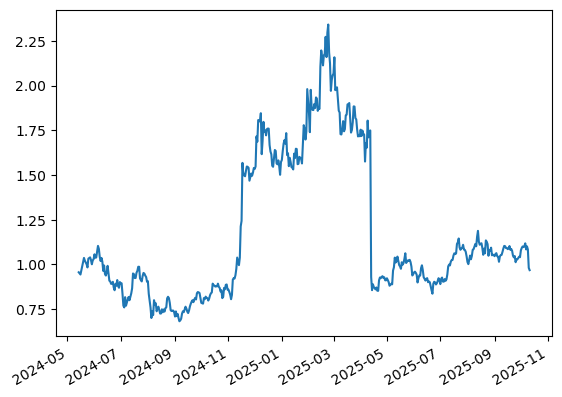

In [54]:
(1+historical_ptf['Historical Portfolio']).cumprod().plot()

In [55]:
(1+historical_ptf['Historical Portfolio'].loc['2025-08-30':]).cumprod()*100

2025-08-30    100.353789
2025-08-31    100.051951
2025-09-01     99.535062
2025-09-02    100.710311
2025-09-03    101.129679
2025-09-04     99.485482
2025-09-05     99.220782
2025-09-06     96.554921
2025-09-07     99.424509
2025-09-08    100.075140
2025-09-09    100.234767
2025-09-10    101.796175
2025-09-11    103.608254
2025-09-12    104.995500
2025-09-13    104.842955
2025-09-14    103.865797
2025-09-15    103.865797
2025-09-16    103.281206
2025-09-17    103.568122
2025-09-18    104.921080
2025-09-19    102.921338
2025-09-20    103.359550
2025-09-21    102.378707
2025-09-22     99.769367
2025-09-23     98.889202
2025-09-24     99.572478
2025-09-25     96.315933
2025-09-26     97.867406
2025-09-27     97.842644
2025-09-28     98.567105
2025-09-29     99.249159
2025-09-30     98.997365
2025-10-01    102.626041
2025-10-02    103.907215
2025-10-03    104.714896
2025-10-04    104.352599
2025-10-05    104.822214
2025-10-06    106.367034
2025-10-07    103.113320
2025-10-08    104.743925


## Ex ante data

In [56]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [57]:
days=120
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [58]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]#,np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [59]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]}])#,
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
BNBUSDT,0.7444
ZECUSDT,0.2556
ALGOUSDT,0.0000
FDUSDUSDT,0.0000
TRXUSDT,0.0000
BTCUSDT,0.0000
WBTCUSDT,0.0000
NEXOUSDT,0.0000
BCHUSDT,0.0000
ETHUSDT,0.0000


In [60]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[cash]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
BNBUSDT,0.744405
ZECUSDT,0.255595


In [61]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))

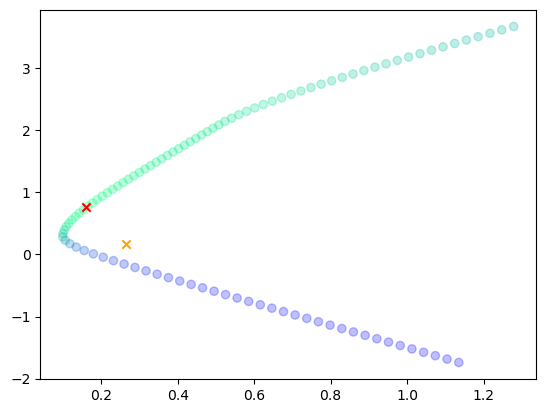

In [62]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [63]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [64]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1389.4194,0.6715,0.0000,0.6715
TRXUSDT,625.3566,0.3022,0.0000,0.3022
OMUSDT,53.7074,0.0260,0.0000,0.0260
USDCUSDT,0.3226,0.0002,0.0000,0.0002
ETHUSDT,0.1505,0.0001,0.0000,0.0001
SOLUSDT,0.0864,0.0000,0.0000,0.0000
BNBUSDT,0.0342,0.0000,0.0968,-0.0968
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
PAXGUSDT,0.0000,0.0000,0.7356,-0.7356
ZECUSDT,0.0000,0.0000,0.0708,-0.0708


### Current results

In [65]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [66]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BNBUSDT,1.0


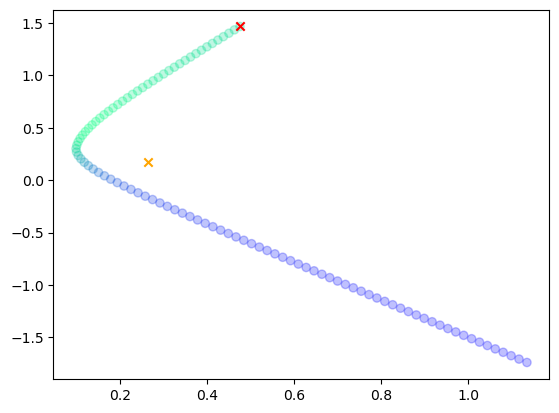

In [67]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [68]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1389.4194,0.6715,0.0,0.6715
TRXUSDT,625.3566,0.3022,0.0,0.3022
OMUSDT,53.7074,0.0260,0.0,0.0260
USDCUSDT,0.3226,0.0002,0.0,0.0002
ETHUSDT,0.1505,0.0001,0.0,0.0001
SOLUSDT,0.0864,0.0000,0.0,0.0000
BNBUSDT,0.0342,0.0000,1.0,-1.0000
PEPEUSDT,0.0000,0.0000,0.0,0.0000


# Risk Reward Analysis

In [69]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [70]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf
portfolio_perf['Model']=performance_model_pct['Fund']

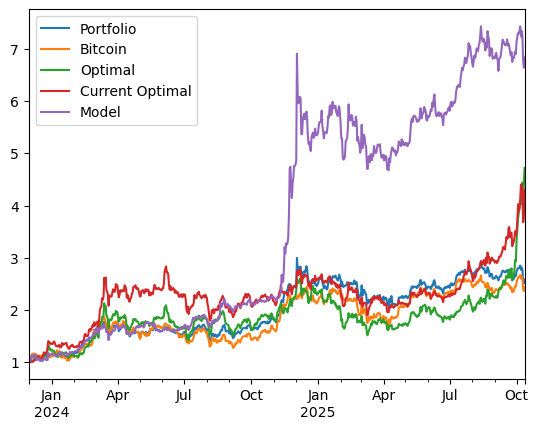

In [71]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [72]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

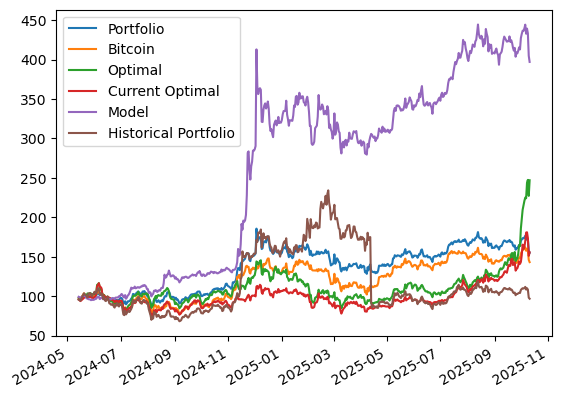

In [73]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


<Axes: >

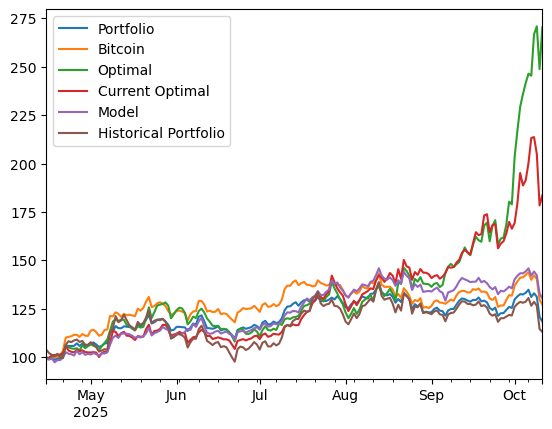

In [74]:
((1+current_perf.loc['2025-04-15':]).cumprod()*100).plot()

<Axes: >

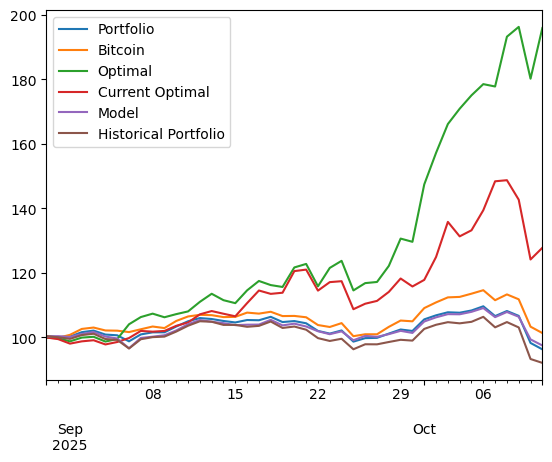

In [75]:
((1+current_perf.loc['2025-08-30':]).cumprod()*100).plot()

In [76]:
((1+current_perf.loc['2025-09':]).cumprod()*100)

,Portfolio,Bitcoin,Optimal,Current Optimal,Model,Historical Portfolio
2025-09-01,100.124689,100.911403,99.029485,98.594495,99.756866,99.483380
2025-09-02,101.500090,102.744604,100.189857,99.305432,100.671284,100.658019
2025-09-03,101.990775,103.173841,100.448579,99.649920,101.276947,101.077169
2025-09-04,100.763394,102.269505,98.969626,98.343836,99.878887,99.433826
2025-09-05,100.534917,102.204021,99.739884,99.099808,99.290841,99.169263
2025-09-06,98.667230,101.767137,104.337310,100.340462,96.253927,96.504786
2025-09-07,100.804242,102.640198,106.573602,102.553817,99.459434,99.372884
2025-09-08,101.450504,103.493588,107.638946,102.323992,99.837152,100.023178
2025-09-09,101.459414,103.013320,106.513799,102.548651,100.280858,100.182721
2025-09-10,103.254886,105.218521,107.489264,104.139714,101.762696,101.743319


## Volatilities

In [77]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.493302
 dtype: float64,
 0.49330156694091176)

In [78]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.264229
 dtype: float64,
 0.26422908772772563)

In [79]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.367577
Bitcoin            0.400442
Optimal            0.465839
Current Optimal    0.458485
Model              0.484789
dtype: float64

In [80]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.18679612441883467

In [81]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

-2.5358721219029023

<Axes: >

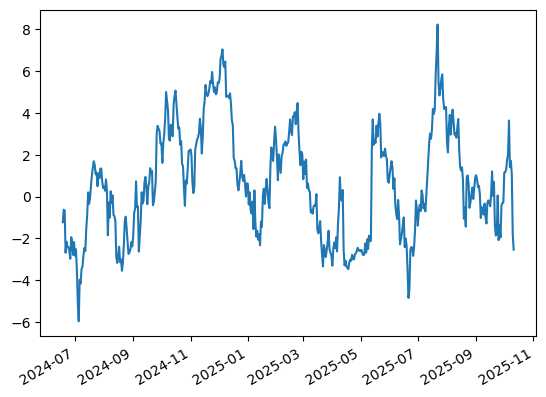

In [82]:
window=30
rolling_sharpe_ratio=current_perf['Historical Portfolio'].rolling(window).mean()*252/(current_perf['Historical Portfolio'].rolling(window).std()*np.sqrt(252))
rolling_sharpe_ratio.plot()

In [83]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.6424505256756473

## Risk Contribution

In [84]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
ZECUSDT,77.6071,0.4619,0.4391,0.0228
BNBUSDT,67.3013,0.5381,0.5153,0.0228
Portfolio,144.9084,1.0000,0.9544,0.0456


In [85]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,90.409543,1.0,1.0,0.0
Portfolio,90.409543,1.0,1.0,0.0


In [86]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
TRXUSDT,5.070935,0.249872,0.099519,0.150353
BTCUSDT,4.278953,0.664840,0.477467,0.187373
OMUSDT,-2.059002,0.085288,0.016613,0.068675
Portfolio,7.290886,1.000000,0.593599,0.406401


# Value At Risk

## Historical

### Optimal Weights

In [87]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.07079488247190542, -0.077986500433993)

### Current Weights

In [88]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.03843379503339058, -0.05900654683752856)

In [89]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [90]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.020267
TRXUSDT     -0.016816
OMUSDT      -0.002214
ETHUSDT     -0.000000
SOLUSDT     -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT    -0.000000
Portfolio   -0.039297
Name: 2025-08-25 00:00:00, dtype: float64

In [91]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.035546
TRXUSDT     -0.015893
OMUSDT      -0.007567
ETHUSDT      0.000000
SOLUSDT      0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.059007
dtype: float64

## Parametric

### Optimal Weights

In [92]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.072291441169266, -0.08953767888121003)

### Current Weights

In [93]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.03872175324544571, -0.047959424403924526)

## Multivariate

### Optimal Weights

In [94]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06349779556429389, -0.07403544615777478)

### Current Weights

In [95]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.03828669856446862, -0.043864703244055905)

In [96]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.025699
TRXUSDT     -0.008821
OMUSDT      -0.003487
Portfolio   -0.038006
dtype: float64

In [97]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.025698
TRXUSDT     -0.008923
OMUSDT      -0.003883
Portfolio   -0.038504
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [98]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06345672212343409, -0.07348632797160354)

### Current Weights

In [99]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.03635225242914843, -0.04184441689273757)

In [100]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [101]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06353157504423886, -0.07340165896885838)

### Current Weights

In [102]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.03914435974815627, -0.04599955740964643)

In [103]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [104]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.16651816850861123, -0.19899619082910444)

### Current Weights

In [105]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07295994644730099, -0.09071548078202829)

In [106]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [107]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [108]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07335182804523355, -0.08385741863035388)

### Current Weights

In [109]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.03830811815239531, -0.04387510947526419)

In [110]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [111]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.036700,-0.025148,-0.017765,-0.025699,-0.026600
TRXUSDT,-0.007561,-0.009139,-0.007425,-0.008821,-0.009149
OMUSDT,-0.001073,-0.003618,-0.002408,-0.003487,-0.003927
Portfolio,-0.045334,-0.037905,-0.027598,-0.038006,-0.039676


In [112]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.038696,-0.025200,-0.017534,-0.025698,-0.027022
TRXUSDT,-0.006803,-0.009491,-0.008077,-0.008923,-0.009246
OMUSDT,-0.000580,-0.003644,-0.002323,-0.003883,-0.003984
Portfolio,-0.046080,-0.038335,-0.027934,-0.038504,-0.040253


## VaR Violation

In [113]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.044660,-0.069543,-0.067665,-0.013890
2024-01-15,-0.044660,-0.072816,-0.068287,0.053592
2024-01-16,-0.044660,-0.072377,-0.068158,-0.010435
2024-01-17,-0.044660,-0.072942,-0.067668,-0.016709
2024-01-18,-0.044660,-0.072400,-0.067055,0.003884
...,...,...,...,...
2025-10-08,-0.069031,-0.095073,-0.073837,0.086826
2025-10-09,-0.069031,-0.094124,-0.074141,0.015755
2025-10-10,-0.079599,-0.103777,-0.084418,-0.081826
2025-10-11,-0.079599,-0.107661,-0.086123,0.087120


In [114]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-15,-0.050603,-0.054522,-0.050108,-0.032094
2023-12-16,-0.050603,-0.054121,-0.049885,0.009522
2023-12-17,-0.050603,-0.055039,-0.053908,-0.016909
2023-12-18,-0.050603,-0.055680,-0.056432,0.016985
2023-12-19,-0.050603,-0.051616,-0.052254,-0.006238
...,...,...,...,...
2025-10-08,-0.033010,-0.039459,-0.035034,0.014751
2025-10-09,-0.033010,-0.040808,-0.037388,-0.013896
2025-10-10,-0.071579,-0.060585,-0.059475,-0.078716
2025-10-11,-0.071579,-0.061291,-0.064505,-0.020092


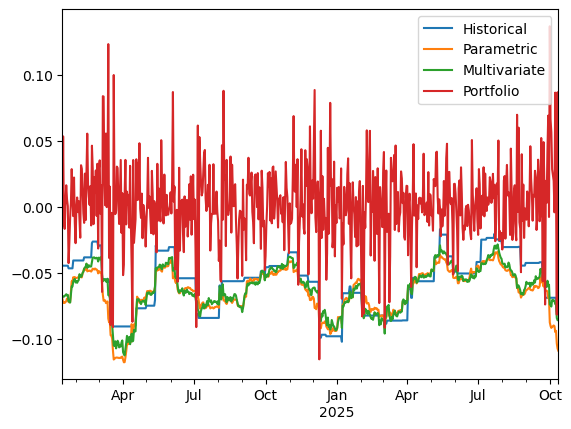

In [115]:
var_data.plot()
plt.show()

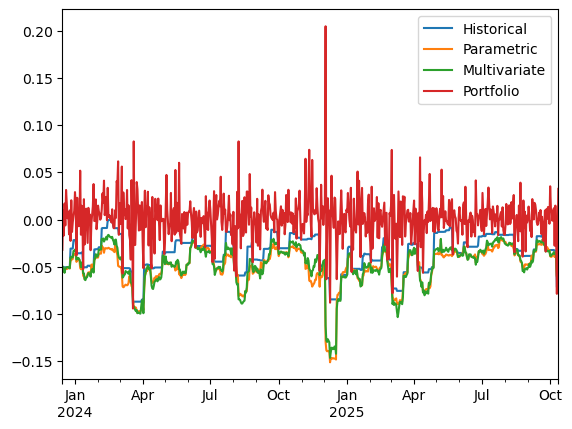

In [116]:
current_var_data.plot()
plt.show()


In [117]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.034483,0.012539,0.015674
Kupiec Stat,3.612036,26.599655,21.381525
P-value,0.057363,0.0,0.000004


In [118]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.070359,0.01497,0.008982
Kupiec Stat,5.203184,23.533013,35.364819
P-value,0.022546,0.000001,0.0


# Principal Component Analysis

## Historical PCA

In [119]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.85316592, 0.06652379, 0.03111268, 0.0255334 , 0.02366422])

In [120]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.020675
ADAUSDT      0.021537
ALGOUSDT     0.023349
APTUSDT      0.022966
ARBUSDT      0.030526
ATOMUSDT     0.022138
AVAXUSDT     0.023852
BCHUSDT      0.011862
BNBUSDT      0.011840
BONKUSDT     0.030680
BTCUSDT      0.007614
CAKEUSDT     0.021757
CRVUSDT      0.028419
DOGEUSDT     0.025016
DOTUSDT      0.024187
ETCUSDT      0.022605
ETHUSDT      0.017438
FDUSDUSDT    0.000134
FETUSDT      0.025026
FILUSDT      0.023336
FLOKIUSDT    0.029263
HBARUSDT     0.023730
ICPUSDT      0.024838
IMXUSDT      0.030489
INJUSDT      0.029545
LDOUSDT      0.029478
LINKUSDT     0.023902
LTCUSDT      0.017942
NEARUSDT     0.022663
NEXOUSDT     0.006924
OMUSDT       0.029318
PAXGUSDT     0.000209
PEPEUSDT     0.027450
QNTUSDT      0.016479
SEIUSDT      0.026657
SHIBUSDT     0.019295
SOLUSDT      0.019411
STXUSDT      0.025488
SUIUSDT      0.024818
TRXUSDT      0.005686
UNIUSDT      0.025068
USDCUSDT     0.000017
VETUSDT      0.023927
WBETHUSDT    0.018308
WBTCUSDT     0.007558
WLDUSDT   

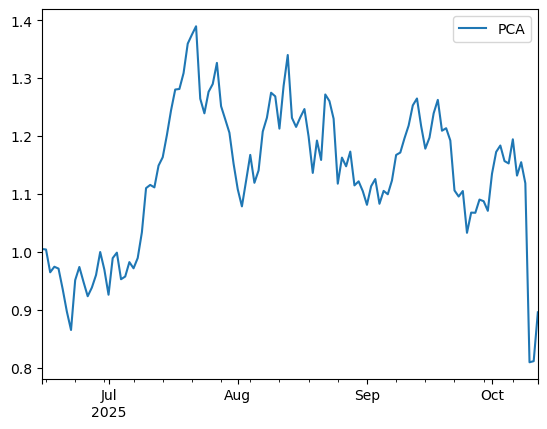

In [121]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

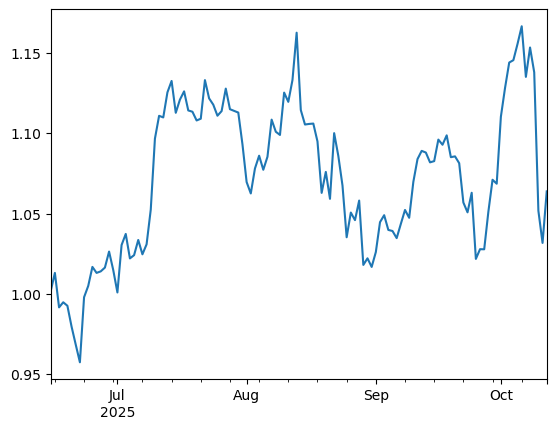

In [122]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [123]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
DOTUSDT      0.130493
SHIBUSDT     0.139191
STXUSDT      0.148096
ICPUSDT      0.150306
VETUSDT      0.154196
FILUSDT      0.159834
ATOMUSDT     0.164153
ADAUSDT      0.178463
PEPEUSDT     0.184803
NEARUSDT     0.193085
ETCUSDT      0.199020
DOGEUSDT     0.201334
WBETHUSDT    0.211924
SUIUSDT      0.216054
INJUSDT      0.223112
LINKUSDT     0.229003
FETUSDT      0.230546
ETHUSDT      0.231742
AAVEUSDT     0.234433
dtype: float64

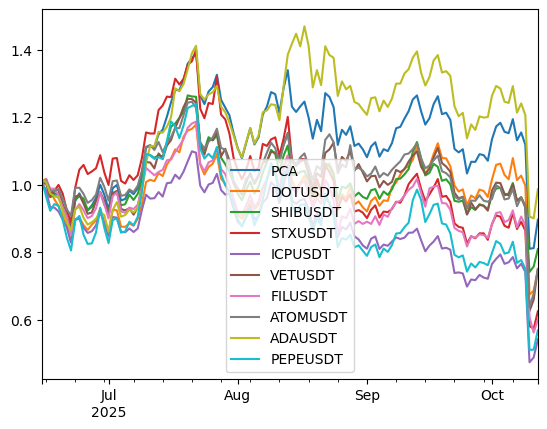

In [124]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

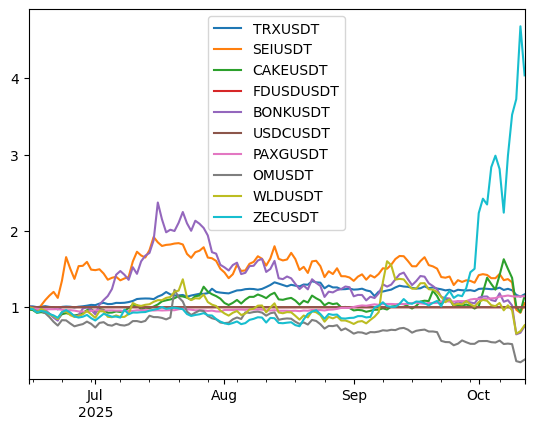

In [125]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [126]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.7946938 , 0.12754493, 0.03279679, 0.02705011, 0.01791437])

In [127]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT     0.058734
TRXUSDT     0.043603
OMUSDT      0.282805
ETHUSDT     0.140700
SOLUSDT     0.156242
BNBUSDT     0.096366
PEPEUSDT    0.220569
PAXGUSDT    0.000982
Name: PC1, dtype: float64

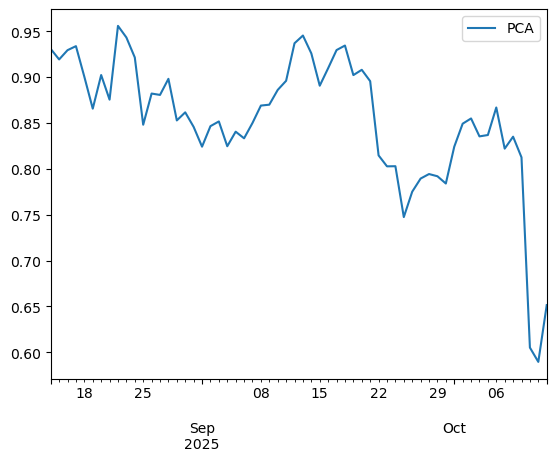

In [128]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA.iloc[-60:]).cumprod().plot()
plt.show()

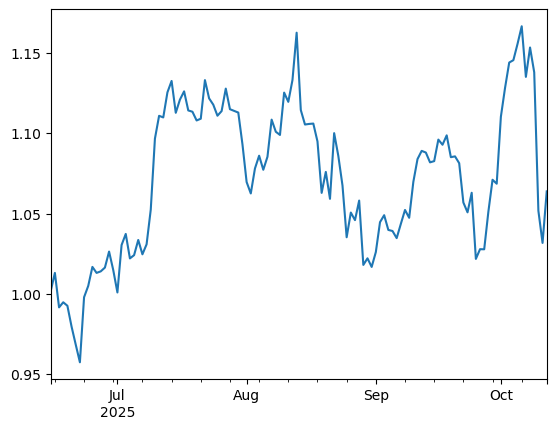

In [129]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [130]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA         0.000000
PEPEUSDT    0.225160
ETHUSDT     0.239007
SOLUSDT     0.252988
BNBUSDT     0.325978
BTCUSDT     0.343638
TRXUSDT     0.394475
OMUSDT      0.407592
PAXGUSDT    0.474332
dtype: float64

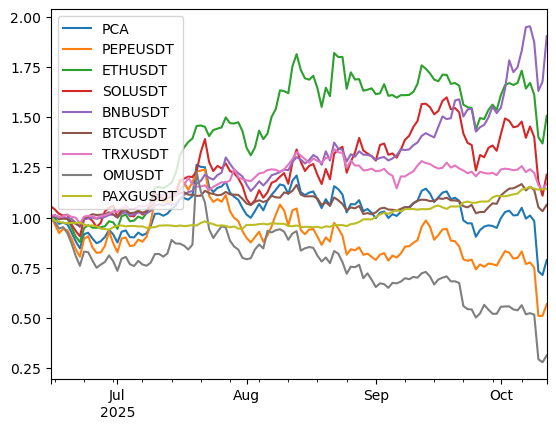

In [131]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [132]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT    1.953778
SOLUSDT     1.326981
ETHUSDT     1.129563
OMUSDT      1.095579
BTCUSDT     1.000000
BNBUSDT     0.698433
TRXUSDT     0.350949
PAXGUSDT    0.029875
Name: BTCUSDT, dtype: float64

In [133]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

OMUSDT      3.540020
PEPEUSDT    2.813561
SOLUSDT     2.110560
ETHUSDT     1.730443
BNBUSDT     1.556368
BTCUSDT     1.000000
TRXUSDT     0.616291
PAXGUSDT    0.036291
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [134]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [135]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
PEPEUSDT,0.532926
TRXUSDT,0.296586
BTCUSDT,0.289387
BNBUSDT,0.120139
OMUSDT,0.107664
ETHUSDT,0.098619
SOLUSDT,-0.076503
PAXGUSDT,-0.116126


### Regression to PCA

In [136]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

2.4638275027457026

In [137]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT     1.214198
ETHUSDT     1.123095
BTCUSDT     1.023635
PCA         1.000000
SOLUSDT     0.801196
PEPEUSDT    0.445879
TRXUSDT     0.379390
PAXGUSDT    0.239640
OMUSDT      0.230667
dtype: float64

In [138]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

TRXUSDT     3.278497
BTCUSDT     2.545732
ETHUSDT     1.397118
SOLUSDT     1.112065
PCA         1.000000
BNBUSDT     0.977235
PEPEUSDT    0.862876
OMUSDT      0.625166
PAXGUSDT    0.145779
dtype: float64

### Correlation Matrix

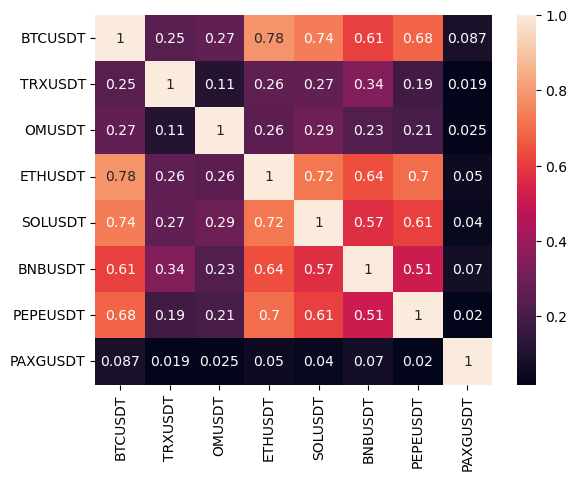

In [139]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

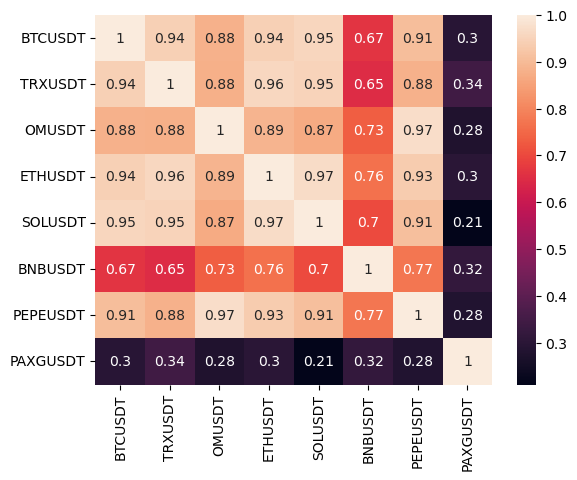

In [140]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [141]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [142]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

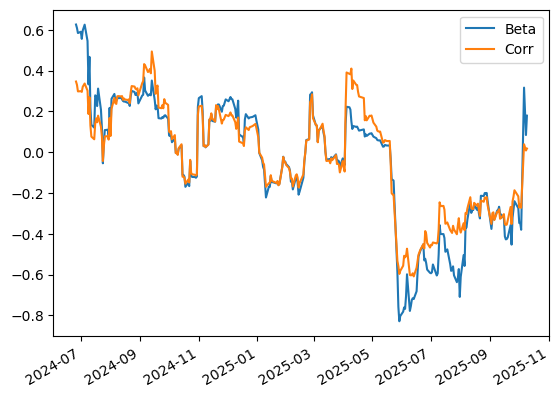

In [143]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [144]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,TRXUSDT,OMUSDT,ETHUSDT,SOLUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2023-12-14,0.107613,0.000000,0.104338,0.000000,0.000000,0.522522,0.000000,0.265527
2023-12-28,0.000000,0.000000,0.000000,0.000000,0.331762,0.668238,0.000000,0.000000
2024-01-11,0.000000,0.000000,0.560261,0.439739,0.000000,0.000000,0.000000,0.000000
2024-01-25,0.000000,0.379495,0.104623,0.000000,0.000000,0.000000,0.000000,0.515881
2024-02-08,0.000000,0.066364,0.047113,0.191143,0.041760,0.000000,0.000000,0.653620
2024-02-22,0.000000,0.705974,0.000000,0.164223,0.000000,0.129803,0.000000,0.000000
2024-03-07,0.000000,0.000000,0.000000,0.020832,0.156080,0.000000,0.046602,0.776486
2024-03-21,0.000000,0.000000,0.462471,0.000000,0.000000,0.471815,0.065714,0.000000
2024-04-04,0.000920,0.000000,0.019296,0.000000,0.000000,0.113904,0.000000,0.865879
2024-04-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [145]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

In [146]:
for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit[0]]-0.0},
                                                                    {'type': 'eq', 'fun': lambda weights: weights[limit[1]]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,ZECUSDT
2025-03-06,0.000000,0.0,0.000003,0.0,0.0,0.000000,0.00000,0.417911,0.000000,0.000000,...,0.191946,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2025-04-05,0.000000,0.0,0.000000,0.0,0.0,0.337897,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.307649
2025-05-05,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000397,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2025-06-04,0.412185,0.0,0.048648,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.230700
2025-07-04,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.805056,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2025-08-03,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.003968,...,0.484820,0.0,0.0,0.0,0.276878,0.0,0.000000,0.048326,0.0,0.000000
2025-09-02,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2025-10-02,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.13356,0.000000,0.404435,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.054114,0.000000,0.0,0.281912
2025-10-12,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.672994,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.327006


In [147]:
rolling_optimization.iloc[-2].sort_values(ascending=False)[:6]

BNBUSDT     0.404435
ZECUSDT     0.281912
AVAXUSDT    0.133560
IMXUSDT     0.125980
WLDUSDT     0.054114
SOLUSDT     0.000000
Name: 2025-10-02 00:00:00, dtype: float64

In [148]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
